In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l1_l2 as l1l2
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

In [4]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [5]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [6]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
__________

In [7]:
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(input=ganInput, output=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


/home/iamcodex/ml/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """


In [8]:
dLosses = []
gLosses = []

In [9]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

In [10]:
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    
    generatedImages = generator.predict(noise)
    
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [11]:
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

In [12]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount
    plotGeneratedImages(0)
    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_a++-
            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 50
Batch size: 128
Batches per epoch: 468
[[ 0.10394893 -0.19356656 -0.11438926 ... -0.17218573  0.31576905
  -0.07766479]
 [ 0.17911194 -0.43308988  0.07139037 ...  0.12614316  0.16319034
  -0.11274195]
 [-0.2469147  -0.5975639  -0.04483305 ... -0.07113379  0.30077747
  -0.24785337]
 ...
 [ 0.01693059 -0.04741535 -0.19256084 ...  0.14539832  0.2192795
  -0.22397003]
 [ 0.13941579 -0.40014577 -0.17449267 ... -0.10781405  0.28889182
  -0.21040744]
 [ 0.19985017 -0.35577825  0.04818258 ...  0.14208345  0.1435509
  -0.34059823]]


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 468/468 [01:01<00:00,  7.66it/s]


[[-0.9262468  -0.63881016 -0.8576397  ... -0.90825397 -0.8791787
  -0.46203253]
 [-0.8214663  -0.9730406  -0.98463637 ... -0.8697657  -0.846228
  -0.88134587]
 [-0.94264597 -0.91116816 -0.90784156 ... -0.95703286 -0.9399506
  -0.641651  ]
 ...
 [-0.8933824  -0.8541824  -0.6780419  ... -0.9635479  -0.66202986
  -0.47765353]
 [-0.8731318  -0.6925917  -0.8801396  ... -0.767321   -0.93617994
  -0.55478054]
 [-0.8169673  -0.9058787  -0.9835072  ... -0.9035761  -0.986389
  -0.8054716 ]]


  0%|          | 1/468 [00:00<00:57,  8.16it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/468 [00:00<01:14,  6.26it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/468 [00:00<01:01,  7.64it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/468 [00:00<01:15,  6.19it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/468 [00:00<01:00,  7.74it/s]

--------------- Epoch 6 ---------------


  0%|          | 1/468 [00:00<01:00,  7.68it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/468 [00:00<00:59,  7.86it/s]

--------------- Epoch 8 ---------------


  0%|          | 1/468 [00:00<00:59,  7.84it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/468 [00:00<01:01,  7.65it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:56<00:00,  8.27it/s]


[[-0.99999154 -0.99974924 -0.23362379 ... -0.99793833 -0.9999989
  -0.9994675 ]
 [-0.99999803 -0.9780406  -0.99979496 ... -1.         -0.28448963
  -0.9999804 ]
 [-0.9999989  -0.99942076 -0.9999887  ... -0.99999326 -0.9999201
  -0.9996927 ]
 ...
 [-0.9999906  -0.9999993  -0.9999991  ... -1.         -1.
  -0.9999688 ]
 [-1.         -1.         -1.         ... -1.         -0.99999994
  -1.        ]
 [-0.9997887  -0.9993257  -0.9956819  ... -0.99998915 -0.90955293
  -0.9939147 ]]


  0%|          | 1/468 [00:00<00:59,  7.86it/s]

--------------- Epoch 11 ---------------


  0%|          | 1/468 [00:00<01:00,  7.68it/s]

--------------- Epoch 12 ---------------


  0%|          | 1/468 [00:00<01:11,  6.49it/s]

--------------- Epoch 13 ---------------


  0%|          | 1/468 [00:00<01:05,  7.14it/s]

--------------- Epoch 14 ---------------


  0%|          | 1/468 [00:00<00:56,  8.30it/s]

--------------- Epoch 15 ---------------


  0%|          | 1/468 [00:00<01:10,  6.58it/s]

--------------- Epoch 16 ---------------


  0%|          | 1/468 [00:00<00:57,  8.15it/s]

--------------- Epoch 17 ---------------


  0%|          | 1/468 [00:00<01:07,  6.90it/s]

--------------- Epoch 18 ---------------


  0%|          | 1/468 [00:00<00:57,  8.12it/s]

--------------- Epoch 19 ---------------


  0%|          | 1/468 [00:00<00:54,  8.57it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [01:00<00:00,  7.73it/s]


[[-0.9999959  -0.99807036 -0.9990489  ... -0.99995744 -0.9993399
  -0.9997532 ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.99999976 -0.9999722  -0.99998266 ... -0.99999744 -1.
  -0.99999994]
 ...
 [-0.9999999  -1.         -0.9999124  ... -1.         -0.9999995
  -0.999992  ]
 [-1.         -1.         -0.9999916  ... -1.         -1.
  -1.        ]
 [-1.         -1.         -0.9999953  ... -1.         -1.
  -0.9999974 ]]


  0%|          | 1/468 [00:00<00:54,  8.58it/s]

--------------- Epoch 21 ---------------


  0%|          | 1/468 [00:00<00:59,  7.79it/s]

--------------- Epoch 22 ---------------


  0%|          | 1/468 [00:00<00:57,  8.15it/s]

--------------- Epoch 23 ---------------


  0%|          | 1/468 [00:00<00:56,  8.20it/s]

--------------- Epoch 24 ---------------


  0%|          | 1/468 [00:00<00:57,  8.15it/s]

--------------- Epoch 25 ---------------


  0%|          | 1/468 [00:00<01:13,  6.34it/s]

--------------- Epoch 26 ---------------


  0%|          | 1/468 [00:00<00:57,  8.14it/s]

--------------- Epoch 27 ---------------


  0%|          | 1/468 [00:00<01:00,  7.73it/s]

--------------- Epoch 28 ---------------


  0%|          | 1/468 [00:00<00:57,  8.08it/s]

--------------- Epoch 29 ---------------


  0%|          | 1/468 [00:00<00:57,  8.13it/s]

--------------- Epoch 30 ---------------


100%|██████████| 468/468 [00:57<00:00,  8.09it/s]


[[-0.9999998  -1.         -1.         ... -1.         -1.
  -1.        ]
 [-0.999997   -0.9999828  -0.99978346 ... -0.99836534 -0.9909413
  -0.99981797]
 [-0.97162175 -0.9816598  -0.99962544 ... -0.9999297  -0.9998207
  -0.99817514]
 ...
 [-0.99993455 -0.9999927  -0.9956255  ... -0.9998315  -0.9991058
  -0.99992603]
 [-0.99999964 -0.9993321  -0.9999932  ... -0.9999279  -1.
  -0.99999976]
 [-1.         -0.99999905 -0.999984   ... -0.9999998  -0.9998602
  -0.99999976]]


  0%|          | 1/468 [00:00<00:53,  8.78it/s]

--------------- Epoch 31 ---------------


  0%|          | 1/468 [00:00<00:55,  8.39it/s]

--------------- Epoch 32 ---------------


  0%|          | 1/468 [00:00<01:13,  6.33it/s]

--------------- Epoch 33 ---------------


  0%|          | 1/468 [00:00<01:09,  6.71it/s]

--------------- Epoch 34 ---------------


  0%|          | 1/468 [00:00<01:04,  7.19it/s]

--------------- Epoch 35 ---------------


  0%|          | 1/468 [00:00<00:56,  8.33it/s]

--------------- Epoch 36 ---------------


  0%|          | 1/468 [00:00<01:11,  6.57it/s]

--------------- Epoch 37 ---------------


  0%|          | 1/468 [00:00<00:53,  8.75it/s]

--------------- Epoch 38 ---------------


  0%|          | 1/468 [00:00<01:03,  7.35it/s]

--------------- Epoch 39 ---------------


  0%|          | 1/468 [00:00<00:56,  8.21it/s]

--------------- Epoch 40 ---------------


100%|██████████| 468/468 [00:57<00:00,  8.08it/s]


[[-0.9998382  -0.99999374 -0.9999627  ... -0.99999577 -0.9999669
  -0.9999944 ]
 [-0.9996421  -0.9991261  -0.9999696  ... -0.9948993  -0.99992746
  -0.9958974 ]
 [-0.99700266 -0.98197246 -0.92891383 ... -0.9917618  -0.99651504
  -0.96500534]
 ...
 [-0.999998   -0.9999998  -1.         ... -1.         -0.999996
  -1.        ]
 [-0.99992293 -0.9996838  -0.99999803 ... -0.999981   -0.9998333
  -0.9995866 ]
 [-0.9999011  -0.9999567  -0.9999195  ... -0.99992543 -0.99999654
  -0.99999964]]


  0%|          | 1/468 [00:00<00:51,  9.10it/s]

--------------- Epoch 41 ---------------


  0%|          | 1/468 [00:00<01:09,  6.68it/s]

--------------- Epoch 42 ---------------


  0%|          | 1/468 [00:00<00:56,  8.29it/s]

--------------- Epoch 43 ---------------


  0%|          | 1/468 [00:00<01:02,  7.45it/s]

--------------- Epoch 44 ---------------


  0%|          | 1/468 [00:00<01:14,  6.29it/s]

--------------- Epoch 45 ---------------


  0%|          | 1/468 [00:00<00:55,  8.37it/s]

--------------- Epoch 46 ---------------


  0%|          | 1/468 [00:00<01:12,  6.48it/s]

--------------- Epoch 47 ---------------


  0%|          | 1/468 [00:00<01:05,  7.08it/s]

--------------- Epoch 48 ---------------


  0%|          | 1/468 [00:00<00:56,  8.31it/s]

--------------- Epoch 49 ---------------


  0%|          | 1/468 [00:00<01:12,  6.44it/s]

--------------- Epoch 50 ---------------


100%|██████████| 468/468 [01:05<00:00,  7.20it/s]


[[-0.99996024 -0.99990004 -0.99999696 ... -0.9998265  -0.99998885
  -0.99710685]
 [-0.99998695 -0.9994107  -0.99996364 ... -0.9922831  -0.9999204
  -0.9999653 ]
 [-0.99573636 -0.9748034  -0.9971278  ... -0.99260294 -0.9970803
  -0.9960972 ]
 ...
 [-0.9997314  -0.99977833 -0.99993354 ... -0.9999937  -0.999996
  -0.9999842 ]
 [-0.9999876  -0.999968   -0.9999544  ... -0.99971336 -0.99988353
  -0.9999668 ]
 [-0.97923046 -0.9998211  -0.9999874  ... -0.9998434  -0.99802274
  -0.99836016]]


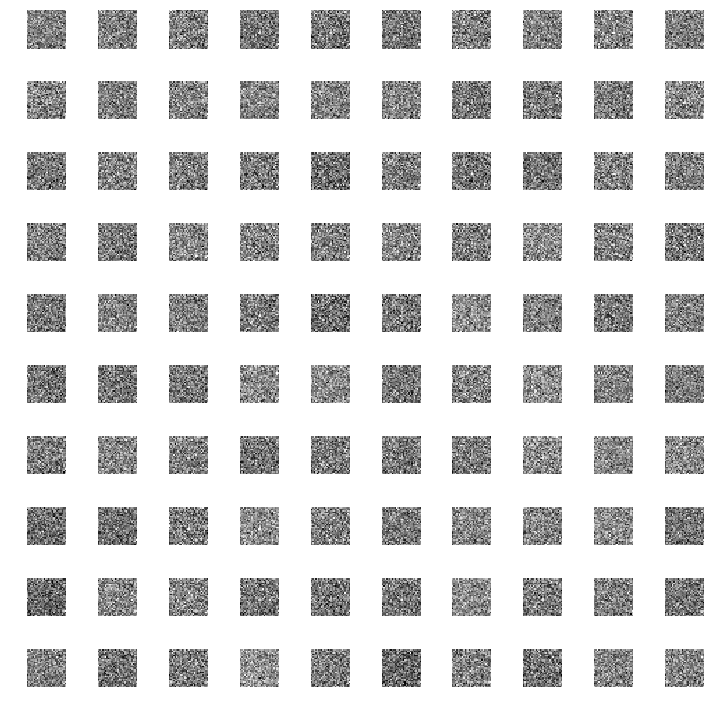

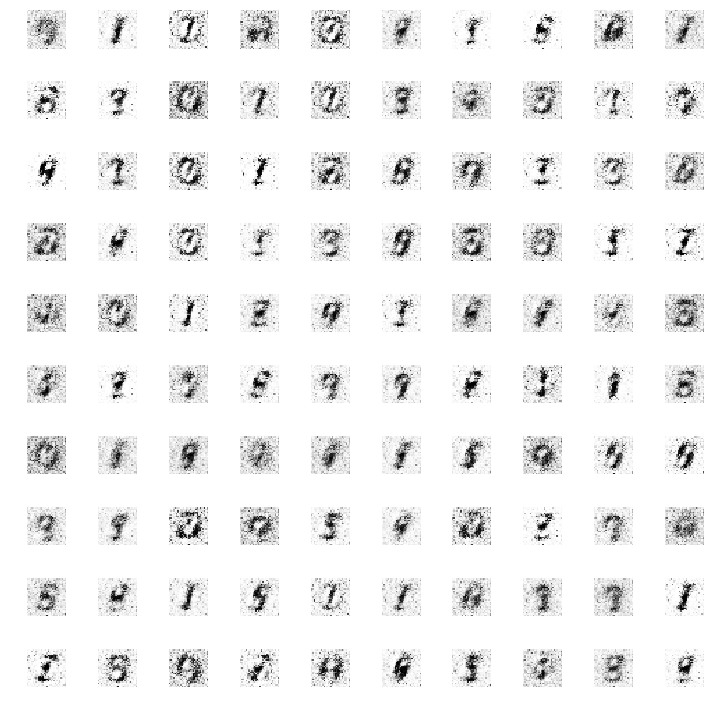

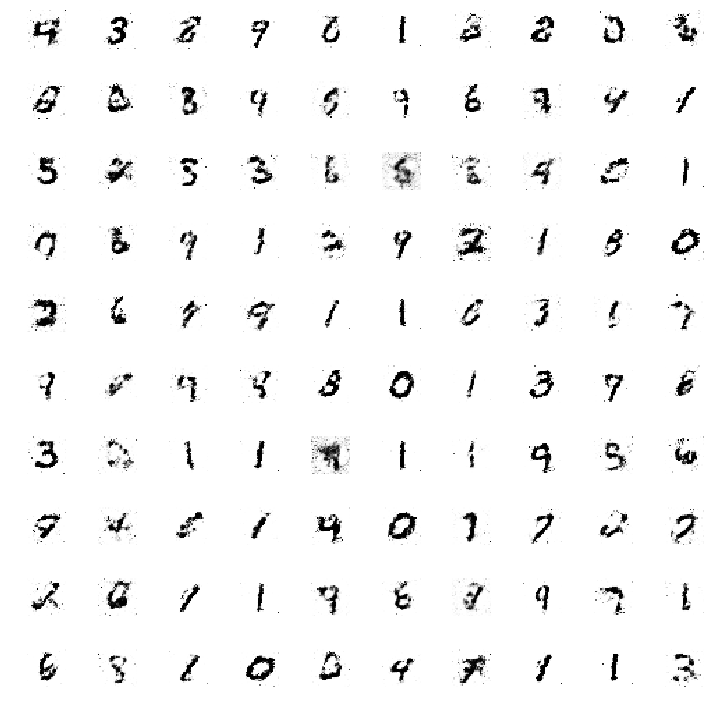

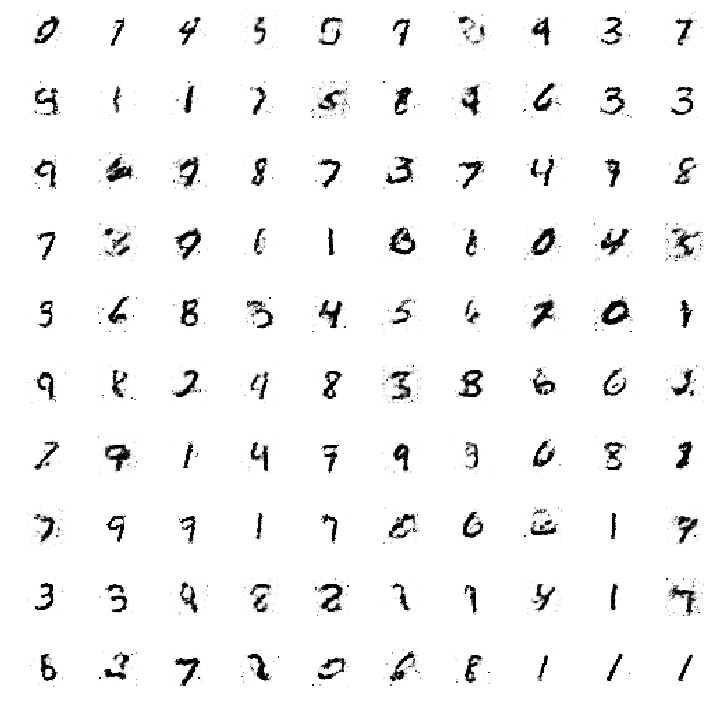

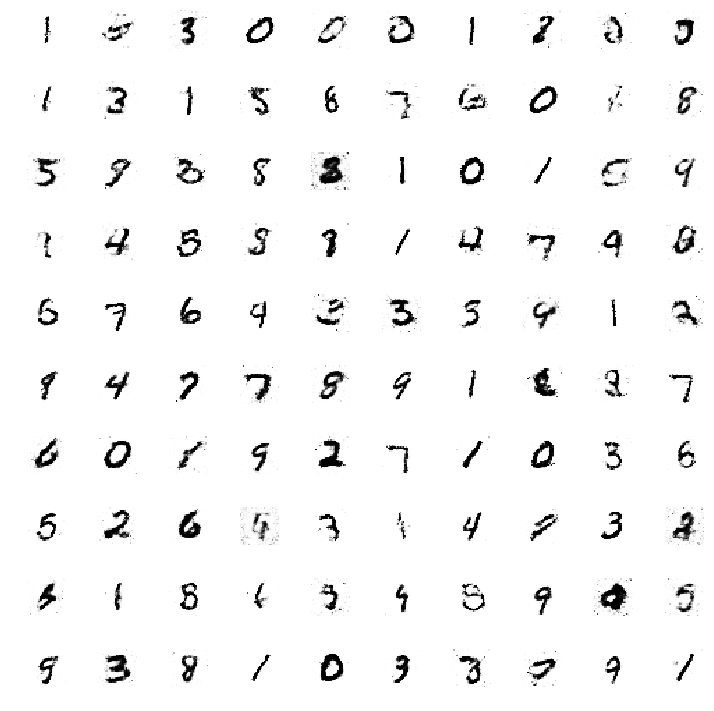

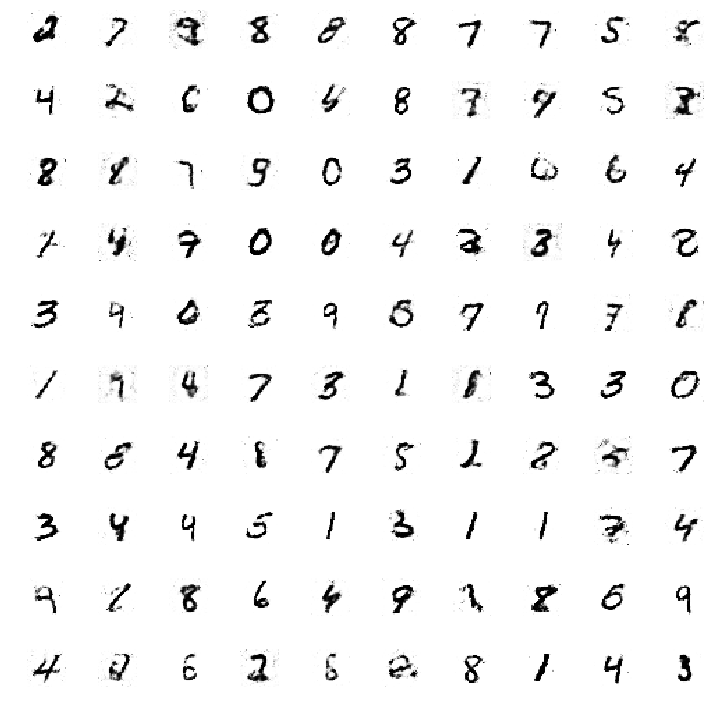

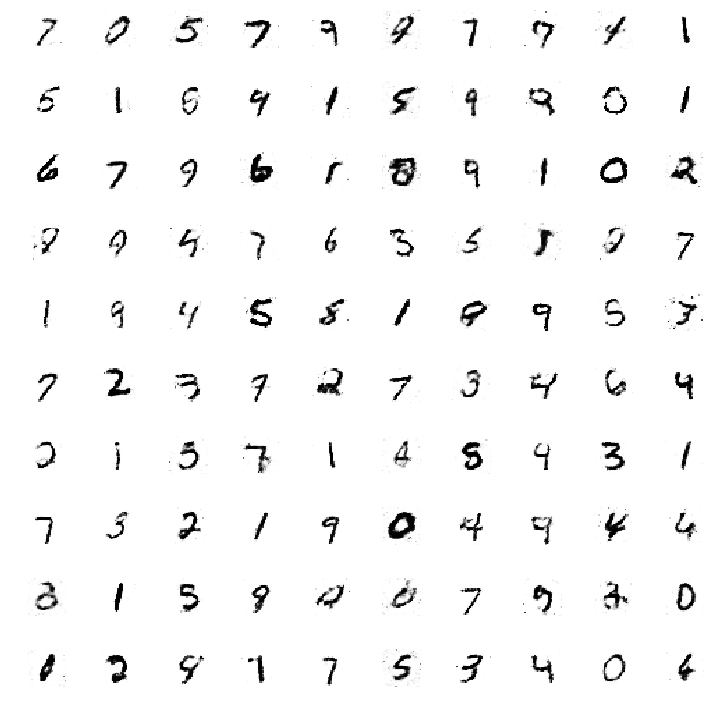

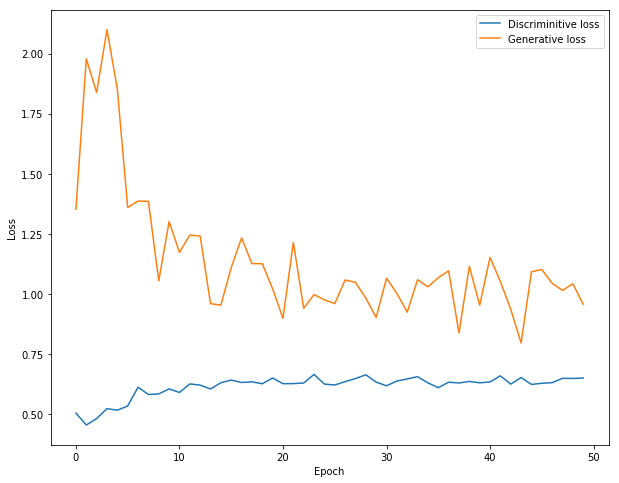

In [13]:
train(50, 128)